In [25]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
import qkeras
import tensorflow as tf 
print(tf.__version__)
print(qkeras.__version__)
print(pd.__version__)
print(np.__version__)
from nn_globals import *
from nn_plotting import __generate_delta_plots__
from dataset import muon_data_split
from nn_evaluate import huber_loss, k_fold_validation
from nn_pruning_module_support import loading_trained_model
from nn_training import train_model, lr_schedule
from keras.models import Model, load_model
from keras.regularizers import L1L2
from tensorflow.keras.optimizers import Adam
from qkeras.qlayers import QDense, QActivation
from keras.layers import Input, BatchNormalization, Dense, Activation
from keras.callbacks import LearningRateScheduler, TerminateOnNaN, ModelCheckpoint, EarlyStopping

2.6.0
0.9.0
1.3.4
1.19.5


In [4]:
# Import muon data
# 'x' is the array of input variables, 'y' is the q/pT
x_train_displ, x_test_displ, y_train_displ, y_test_displ, dxy_train_displ, dxy_test_displ= muon_data_split(filename=DATAFILEPATH, 
                                                                                                           reg_pt_scale=REG_PT_SCALE, 
                                                                                                           reg_dxy_scale=REG_DXY_SCALE, 
                                                                                                           test_size=TEST_SIZE,
                                                                                                           nvariables = NVARIABLES,
                                                                                                           nentries= NENTRIES,
                                                                                                           batch_size = 128)


[INFO    ] Loading muon data from ./data/NN_input_params_FlatXYZ.npz ...
[INFO    ] Loaded the variables with shape (19300000, 25)
[INFO    ] Loaded the parameters with shape (19300000, 6)
[INFO    ] Loaded the encoded variables with shape (3284620, 23)
[INFO    ] Loaded the encoded parameters with shape (3284620,)
[INFO    ] Loaded # of training and testing events: (2249964, 1034656)
[WARNING ] The last batch for training could be too few! (2024967%128)=7. Please change test_size.
[WARNING ] Try this formula: int(int(3284620*0.685)*0.9) % 128
[WARNING ] The last batch for training after mixing could be too few! (4049935%128)=15. Please change test_size.
[WARNING ] Try this formula: int(int(3284620*0.685)*2*0.9) % 128


In [6]:
unquantized_model = loading_trained_model(filepath = "./models",
                                          model_filename = "baseline_reduced_dim_0.5")
unquantized_model.summary()

./models/baseline_reduced_dim_0.5.json
./models/baseline_reduced_dim_0.5_weights.h5
Metal device set to: Apple M1
Loaded model from disk
Model: "baseline-model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 23)]              0         
_________________________________________________________________
bn-input (BatchNormalization (None, 23)                92        
_________________________________________________________________
hidden-dense-1 (Dense)       (None, 10)                230       
_________________________________________________________________
bn-1 (BatchNormalization)    (None, 10)                40        
_________________________________________________________________
act_1 (Activation)           (None, 10)                0         
_________________________________________________________________
hidden-dense-2 (Dense)       (None, 7)         

2022-01-12 11:19:05.950201: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-12 11:19:05.950938: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
def set_weights_from_baseline(baseline, qmodel):
    layer_config = []
    for layer in baseline.layers:
        layer_config.append(layer.get_weights())
    for i in range(1,len(qmodel.layers)-1):
        layer = qmodel.layers[i]
        if "act" in layer.name:
            i+=1
        else:
            layer.set_weights(layer_config[i])
    return qmodel

def create_model_quantized(baseline,
                           bits, 
                           int_bits, 
                           nvariables, 
                           lr=0.001, 
                           clipnorm=10., 
                           initializer = "he_uniform",
                           nodes1=64, 
                           nodes2=32, 
                           nodes3=16, 
                           outnodes=2,
                           l1_reg = 0.0, 
                           l2_reg = 0.0):
  
    # intializing the quantizers and layer variables
    kernelQuantizer = "quantized_bits(bits={},integer={},symmetric = True,use_stochastic_rounding=True, qnoise_factor = 1.0, alpha = 1.0)".format(bits, int_bits)
    # activationQuantizer = "quantized_relu(bits={},integer={}, use_sigmoid=True,use_stochastic_rounding=True, qnoise_factor = 1.0)".format(bits,int_bits)
    activationQuantizer = "quantized_tanh(bits ={}, symmetric = True, use_stochastic_rounding=True, use_real_tanh =True)".format(bits)
    regularizer = L1L2(l1=l1_reg, l2=l2_reg)
    bn_momentum = 0.9
    eps = 1e-4

    x = x_in = Input((nvariables,))
    x = BatchNormalization(epsilon=eps, momentum=bn_momentum,name="bn-input")(x)
    
    x = QDense(nodes1, 
               kernel_quantizer = "quantized_bits(bits={},integer={},symmetric = False,use_stochastic_rounding=True, qnoise_factor = 1.0, alpha = 1.0)".format(bits, int_bits),
               kernel_initializer=initializer,
               use_bias = False,
               kernel_regularizer = regularizer,
               name="hidden-dense-1")(x)
    x = BatchNormalization(epsilon = eps, momentum  = bn_momentum, name = "bn-1")(x)
    x = QActivation(activation = activationQuantizer,
                    name="act_1")(x)
    
    if nodes2:
    
        x = QDense(nodes2, 
                   kernel_quantizer = kernelQuantizer, 
                   kernel_initializer=initializer,
                   use_bias = False,
                   kernel_regularizer = regularizer,
                   name="hidden-dense-2")(x)
        x = BatchNormalization(epsilon = eps, momentum  = bn_momentum, name = "bn-2")(x)
        x = QActivation(activation = activationQuantizer,
                    name="act_2")(x)
        if nodes3:

            x = QDense(nodes3, 
                       kernel_quantizer = kernelQuantizer, 
                       kernel_initializer=initializer,
                       kernel_regularizer = regularizer,
                       use_bias = False,
                       name="hidden-dense-3")(x)
            x = BatchNormalization(epsilon = eps, momentum  = bn_momentum, name = "bn-3")(x)
            x = QActivation(activation = activationQuantizer, 
                            name="act_3")(x)

    x = QDense(outnodes,
                kernel_quantizer = kernelQuantizer,
                kernel_initializer = initializer,
                use_bias = True,
                name="dense-output")(x)
    x = Activation("linear")(x)
    
    model = Model(inputs=x_in, outputs=x,name="quantized-model")
    
    adam = tf.keras.optimizers.Adam(lr=lr, 
                                    clipnorm=clipnorm)
    model.compile(optimizer=adam, 
                  loss=huber_loss, 
                  metrics=['acc','mse','mae'])
    # transfer the pre-trained model's final weights to the quantized model
    model = set_weights_from_baseline(baseline, model)
    model.summary()
    return model
    

In [27]:
bits = 8
ints = 4

normal_epochs = 400
normal_batch_size = 2000
l1_reg = 0.0
l2_reg = 0.0
learning_rate = 0.075
gradient_clip_norm = 100.
initializer = "glorot_uniform"
# callbacks
lr_decay = LearningRateScheduler(lr_schedule)
terminate_on_nan = TerminateOnNaN()
early_stopping = EarlyStopping(monitor = "val_loss", 
                               min_delta= 1e-4, 
                               mode = "auto", 
                               patience = 20)
model_ckpt = ModelCheckpoint(monitor="val_loss", 
                           verbose = 1,
                           filepath = "./checkpoints/quantized_model_0.5_ckpt_epoch_{epoch:02d}.hdf5",
                           period = 5)

qmodel = create_model_quantized(baseline = unquantized_model,
                                bits = bits,
                                int_bits = ints,
                                nvariables = NVARIABLES, 
                                lr = learning_rate, 
                                clipnorm = gradient_clip_norm, 
                                nodes1=10, 
                                nodes2=7, 
                                nodes3=5, 
                                outnodes=2,
                                initializer = initializer,
                                l1_reg = l1_reg, 
                                l2_reg = l2_reg)

logger.info('Training model with l1_reg: {0} l2_reg: {1}'.format(l1_reg, l2_reg))

qmodel, history = train_model(qmodel, 
                      x_train_displ, 
                      np.column_stack((y_train_displ, dxy_train_displ)),
                      save_model=False, 
                      epochs=normal_epochs, 
                      batch_size=normal_batch_size,
                      callbacks=[lr_decay,
                                 terminate_on_nan,
                                 early_stopping,
                                 model_ckpt], 
                      validation_split=0.1, 
                      verbose=True)

metrics = [len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]]
logger.info('Epoch {0}/{0} - loss: {1} - val_loss: {2}'.format(*metrics))

/Users/gpradhan/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
[INFO    ] Training model with l1_reg: 0.0 l2_reg: 0.0
[INFO    ] Begin training ...


Model: "quantized-model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 23)]              0         
_________________________________________________________________
bn-input (BatchNormalization (None, 23)                92        
_________________________________________________________________
hidden-dense-1 (QDense)      (None, 10)                230       
_________________________________________________________________
bn-1 (BatchNormalization)    (None, 10)                40        
_________________________________________________________________
act_1 (QActivation)          (None, 10)                0         
_________________________________________________________________
hidden-dense-2 (QDense)      (None, 7)                 70        
_________________________________________________________________
bn-2 (BatchNormalization)    (None, 7)             

2022-01-12 13:37:45.691225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1013/1013 [==============================] - ETA: 0s - loss: 14.5771 - acc: 0.9327 - mse: 310.0107 - mae: 11.4840

2022-01-12 13:38:06.923103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1013/1013 [==============================] - 23s 22ms/step - loss: 14.5771 - acc: 0.9327 - mse: 310.0107 - mae: 11.4840 - val_loss: 13.5867 - val_acc: 0.9367 - val_mse: 263.6441 - val_mae: 10.7467
Epoch 2/400
1013/1013 [==============================] - 24s 23ms/step - loss: 13.6591 - acc: 0.9346 - mse: 263.5576 - mae: 10.8010 - val_loss: 13.5923 - val_acc: 0.9367 - val_mse: 262.6001 - val_mae: 10.7509
Epoch 3/400
1013/1013 [==============================] - 21s 20ms/step - loss: 13.6212 - acc: 0.9347 - mse: 262.4961 - mae: 10.7726 - val_loss: 13.6678 - val_acc: 0.9330 - val_mse: 264.0602 - val_mae: 10.8082
Epoch 4/400
1013/1013 [==============================] - 20s 20ms/step - loss: 13.5987 - acc: 0.9349 - mse: 261.9934 - mae: 10.7558 - val_loss: 13.6286 - val_acc: 0.9347 - val_mse: 263.1693 - val_mae: 10.7779
Epoch 5/400
1013/1013 [==============================] - 20s 20ms/step - loss: 13.6097 - acc: 0.9345 - mse: 262.1906 - mae: 10.7641 - val_loss: 13.4903 - val_acc: 0.9370 - val_

1013/1013 [==============================] - 23s 23ms/step - loss: 13.3276 - acc: 0.9350 - mse: 257.1952 - mae: 10.5527 - val_loss: 13.2545 - val_acc: 0.9344 - val_mse: 255.4129 - val_mae: 10.4988
Epoch 38/400
1013/1013 [==============================] - 21s 21ms/step - loss: 13.3360 - acc: 0.9349 - mse: 257.2811 - mae: 10.5590 - val_loss: 13.2047 - val_acc: 0.9371 - val_mse: 255.7591 - val_mae: 10.4602
Epoch 39/400
1013/1013 [==============================] - 22s 22ms/step - loss: 13.3407 - acc: 0.9349 - mse: 257.4052 - mae: 10.5625 - val_loss: 13.2929 - val_acc: 0.9372 - val_mse: 257.9536 - val_mae: 10.5268
Epoch 40/400
1013/1013 [==============================] - 23s 22ms/step - loss: 13.3377 - acc: 0.9350 - mse: 257.4196 - mae: 10.5602 - val_loss: 13.4873 - val_acc: 0.9341 - val_mse: 262.8503 - val_mae: 10.6712

Epoch 00040: saving model to ./checkpoints/quantized_model_0.5_ckpt_epoch_40.hdf5
Epoch 41/400
1013/1013 [==============================] - 21s 21ms/step - loss: 13.3089 - 

[INFO    ] Done training. Time elapsed: 0:18:44.705806 sec
[INFO    ] Epoch 52/52 - loss: 13.303789138793945 - val_loss: 13.24991226196289


MAE as obtained on test dataset:


2022-01-12 13:56:30.077081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Mean MAE for 1-Fold cv for momentum = 11.774854921997681
Mean MAE for 1-Fold cv for displacement = 15.274830393718315
RMSE as obtained on test dataset:
Mean RMSE for 1-Fold cv for momentum = 54.35100896892075
Mean RMSE for 1-Fold cv for displacement = 21.21659059172043


[INFO    ] # of entries: 1034656, mean: 0.02706455695860494, std: 0.19501568248208578
[INFO    ] gaus fit (a, mu, sig): [ 4.22548298e+04 -2.62976076e-02  3.45261503e-01]


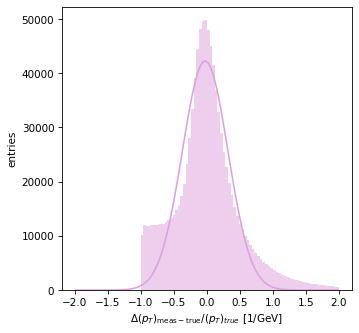

[INFO    ] # of entries: 150336, mean: -1.0915630611214449, std: 18.00020187466566
[INFO    ] gaus fit (a, mu, sig): [ 6.93089986e+03 -1.29036498e+00  6.80605342e+00]


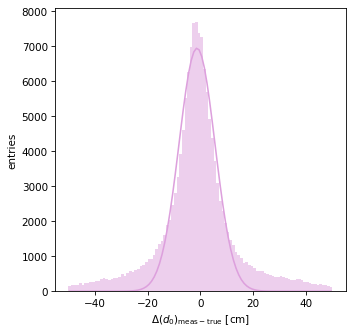

In [28]:
print("MAE as obtained on test dataset:")
k_fold_validation(model = qmodel, 
                  x = x_test_displ,  
                  y = y_test_displ, 
                  dxy = dxy_test_displ, 
                  folds = 1,
                  metric_type="MAE")

print("RMSE as obtained on test dataset:")
k_fold_validation(model = qmodel, 
                  x = x_test_displ,  
                  y = y_test_displ, 
                  dxy = dxy_test_displ, 
                  folds = 1,
                  metric_type = "RMSE")

# Evaluate the quantized resolution
__generate_delta_plots__(model = qmodel,
                        x = x_test_displ,
                        y = y_test_displ,
                        dxy = dxy_test_displ,
                        color = "plum"
                        )

In [23]:
def save_qmodel(model_for_export,
                bits: int = 8,
                int_bits: int = 0,
                sparsity: int = 0):
    
    if sparsity:
        qkeras_file ="./models/quantized_bits_{}_int_{}_sparsity_{}.h5".format(bits, int_bits, sparsity)
        weights_file = "./models/quantized_bits_{}_int_{}_sparsity_{}_weights.h5".format(bits, int_bits, sparsity)
        model_for_export.save(filepath = qkeras_file, include_optimizer=False)
        qkeras.utils.model_save_quantized_weights(model_for_export, weights_file)
    else:
        qkeras_file = "./models/quantized_model_bits_{}_int_{}_sparsity_0.h5".format(bits, int_bits)
        weights_file = "./models/quantized_model_bits_{}_int_{}_sparsity_0_weights.h5".format(bits, int_bits)
        model_for_export.save(filepath = qkeras_file, include_optimizer=False)
        qkeras.utils.model_save_quantized_weights(model_for_export, weights_file)      

def save_training_history(training_history_dict,
                          bits:int = 8, 
                          int_bits:int = 0, 
                          sparsity: int = 0):
    filename = "trainHistoryDict_model_bits_{}_ints_{}_sparsity_{}".format(bits, int_bits, sparsity)
    with open(filename, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [29]:
save_qmodel(qmodel, 
            bits = 8,
            int_bits = 4,
            sparsity = 0)

save_training_history(history,
                      bits = 8,
                      int_bits = 4,
                      sparsity = 0)

... quantizing model
  bn-input has not been quantized
  bn-1 has not been quantized
  bn-2 has not been quantized
  bn-3 has not been quantized
